In [ ]:
import numpy as np
import cv2
import sys
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import matplotlib.pyplot as plt


# display images

288
384


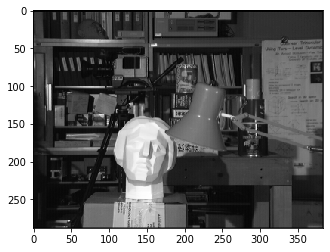

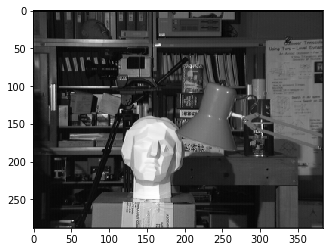

In [ ]:
imgL = cv2.imread('StereoL1.png',0)
imgR = cv2.imread('StereoR1.png',0)
plt.figure()
plt.imshow(imgL, cmap="gray")
plt.figure()
plt.imshow(imgR, cmap="gray")

rows, cols = imgL.shape
print(rows)
print(cols)


# dynamic programming

## sum of Sum of Squared Differences 

In [ ]:
def SSD(pixelL,pixelR,sigma=2):
  ssd = (pixelL-pixelR)**2/(sigma**2)
  return ssd

## we take each row from both images and compute a forward matching and then backtrack the best path

In [ ]:
def dynamic_matching_forward(rowL, rowR):
  
  N = rowL.shape[0]
  M = rowR.shape[0]
  cost_matrix = np.ones((N,M))
  match_matrix = np.zeros((N,M))

  occlusion_cost = 1

  cost_matrix[0][0] = SSD(rowL[0], rowR[0])

  for i in range(1, N):
    cost_matrix[i][0] = i*occlusion_cost
  for j in range(1, M):
    cost_matrix[0][j] = j*occlusion_cost

  
  for i in range(1, N):
      for j in range(1, M):
        min1 = cost_matrix[i - 1][j -1] + SSD(rowL[i], rowR[j])
        min2 = cost_matrix[i - 1][j] + occlusion_cost
        min3 = cost_matrix[i][j - 1] + occlusion_cost

        cost_matrix[i][j] = cmin = min(min1, min2, min3)

        if(cmin == min1):
          match_matrix[i][j] = 1
        elif(cmin == min2):
          match_matrix[i][j] = 2
        elif(cmin == min3):
          match_matrix[i][j] = 3

  #match_matrix[N-1][M-1] = 1

  return (match_matrix, cost_matrix)


In [ ]:
def dynyamic_matching_backtrack(match_matrix):
  rowL = rowR = match_matrix.shape[0]-1
  disp_vec = np.zeros((match_matrix.shape[0],1))
  disp_acc = 0

  x=list()
  y=list()

  opt_path = np.zeros((match_matrix.shape[0]**2))
  opt_pos = 0
  while(rowL!=0 and rowR!=0):
    z = match_matrix[rowL][rowR]

    x.append(rowL)
    y.append(rowR)

    if(z==1):
      rowL -= 1 
      rowR -= 1
      disp_vec[rowL] = abs(rowR-rowL)
    elif(z==2):
      rowL -= 1 
      disp_acc += 1
      disp_vec[rowL] = 0
    elif(z==3):
      rowR -= 1
      disp_acc -= 1
    
  return (disp_vec, x,y)

In [ ]:
def result_disparity(img, disp):
  cv2_imshow(img)
  factor = 255/max(np.unique(disp))
  cv2_imshow(disp*factor)
  return 

# main function

In [ ]:
def dynamic_disparity(imgL, imgR):
  imgL_bw = np.asarray(cv2.imread(imgL,0), dtype = np.float32)
  imgR_bw = np.asarray(cv2.imread(imgR,0), dtype = np.float32)
  
  disp_map = np.zeros(imgR_bw.shape)

  x_matrix=list()
  y_matrix=list()


  for row in tqdm(range(imgL_bw.shape[0])):
    row_match_matrix, row_cost_matrix = dynamic_matching_forward(imgL_bw[row], imgR_bw[row])
    # print("row_cost_matrix: ", row_cost_matrix)
    # print("row_match_matrix: ",row_match_matrix)

    disp_row, x,y = dynyamic_matching_backtrack(row_match_matrix)

    x_matrix.append(x)
    y_matrix.append(y)

    # plot_path(opt_path)

    disp_map[row] = disp_row.reshape(imgL_bw.shape[1])
    # print("disp_row: ", disp_row)
  result_disparity(imgL_bw, disp_map)  

  return (disp_map,x_matrix,y_matrix)

# Result

100%|██████████| 288/288 [04:38<00:00,  1.04it/s]


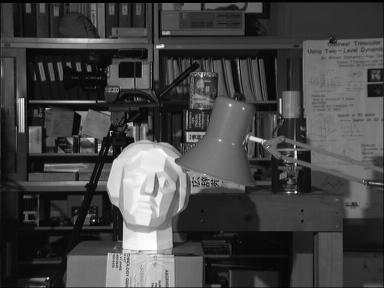

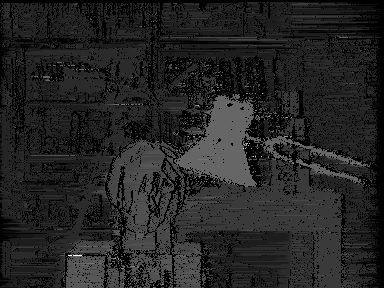

In [ ]:
# np.set_printoptions(threshold=sys.maxsize)

imgL = '/content/StereoL1.png'
imgR = '/content/StereoR1.png'

disp,x_matrix,y_matrix = dynamic_disparity(imgL, imgR)

# cv2_imshow(disp)